# Lecture 9: Accelerating SGD with Preconditioning and Adaptive Learning Rates

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\norm}[1]{\left\|#1\right\|}$
$\newcommand{\Exv}[1]{\mathbf{E}\left[#1\right]}$
$\newcommand{\Prob}[1]{\mathbf{P}\left(#1\right)}$
$\newcommand{\Var}[1]{\operatorname{Var}\left(#1\right)}$
$\newcommand{\Abs}[1]{\left|#1\right|}$

In [1]:
import numpy
import scipy
import matplotlib
from matplotlib import pyplot
import time

matplotlib.rcParams.update({'font.size': 14, 'figure.figsize': (6.0, 6.0)})

## Announcements

**We're still grading the prelim.** The solutions have been released on Canvas.

Second pset with late days due **tonight**.

Second programming assignment out **tonight**.

## Recall

Strongly convex optimization problems are poorly conditioned when the condition number $\kappa$ is large.

* The number of steps of gradient descent required to guarantee a certain objective gap $\epsilon$ is proportional to the condition number.

We said last time that intuitively, we’d like to **set the step size larger for directions with less curvature, and smaller for directions with more curvature**.

* But we couldn't do this with plain GD or SGD, because there is only one step-size parameter.

Last time: **momentum** 

* adds a momentum term that uses past steps to amplify the gradient in directions that are consistently the same sign and dampens the gradient in directions that are reversing sign.

Today we'll talk about two other methods for addressing the issue of conditioning: **preconditioning**, and **adaptive learning rates**.

# Preconditioning

Motivation: One way to think about a large condition number is graphically/geometrically.

* ...in terms of how it affects the **level sets** of the optimization problem.

The "level sets" of a function $f: \R^d \rightarrow \R$ are the sets $\{ w \mid f(w) = C \}$ at which $f$ takes on one particular value. They are one way to visualize the curvature of the function.


Let's look at our poorly conditioned optimization problem example from last time, the two-dimensional quadratic

$$f(w) = f(w_1, w_2) = \frac{L}{2} w_1^2 + \frac{\mu}{2} w_2^2 = \frac{1}{2} \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}^T \begin{bmatrix} L & 0 \\ 0 & \mu \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}.$$

Here, the level sets of $f$ are the sets on which $f(w) = C$ for some constant $C$, which take the form

$$2C = L w_1^2 + \mu w_2^2.$$

<span style="color:forestgreen;font-size:larger;font-weight:bold">What is the geometric shape this equation represents?</span>

These are **ellipses**! Let's plot some. We can parameterize this with $w_1 = \sqrt{\frac{2C}{L}} \cdot \cos(\theta)$ and $w_2 = \sqrt{\frac{2C}{\mu}} \cdot \sin(\theta)$.

In [2]:
def plot_levelsets(L, mu):
    t = numpy.linspace(0, 2*numpy.pi, 128)
    for C in (((L + mu)/2) * numpy.linspace(0.1,1.9,8)**2):
        x = numpy.cos(t) / numpy.sqrt(L / (2*C))
        y = numpy.sin(t) / numpy.sqrt(mu / (2*C))
        pyplot.plot(x, y, label=f"C = {C:.3f}")
    pyplot.axis("square")
    pyplot.xlim([-2,2])
    pyplot.ylim([-2,2])
    pyplot.title(f"Level Sets of $f(w_1, w_2) = \\frac{{{L}}}{{2}} w_1^2 + \\frac{{{mu}}}{{2}} w_2^2$")
    pyplot.xlabel("$w_1$")
    pyplot.ylabel("$w_2$")
    pyplot.legend(bbox_to_anchor=(1.04,1),loc="upper left")

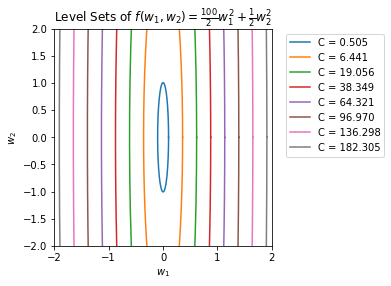

In [5]:
plot_levelsets(100, 1)

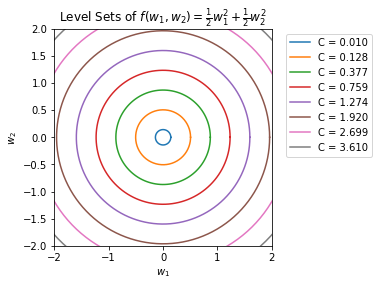

In [4]:
plot_levelsets(1, 1)

### Main Idea of Preconditioning

The learning problem we are solving is invariant to shifts and scales of the weight space. That is, if I scale the weight space, solve the problem in the scaled space, and then scale it back, I'll have the solution to the original problem.
**Idea: Rescale the underlying space we're optimizing over to make the level sets more like circles.**

To do this for an objective function $f$, let's imagine solving the modified optimization problem where we minimize $g(u) = f(R u)$ for some fixed matrix $R$.

First, we need to find the gradient of $g$. Observe that

$$g(u + \eta v) = f(R (u + \eta v)) = f(Ru + \eta Rv)$$

so

$$\left. \frac{d}{d \eta} g(u + \eta v) \; \right|_{\eta = 0} = \left. \frac{d}{d \eta} f(Ru + \eta Rv) \; \right|_{\eta = 0} = (Rv)^T \nabla f(Ru) = v^T R^T \nabla f(Ru)$$

which lets us conclude that $\nabla g(u) = R^T \nabla f(Ru)$, so gradient descent will look like

$$u_{t+1} = u_t - \alpha \nabla g(u_t) = u_t - \alpha R^T  \nabla f(R u_t).$$

If we multiply both sides by $R$, and let $w_t$ denote the corresponding value to $u_t$ in the original weight space, i.e. $w_t = R u_t$, we get

$$w_{t+1} = R u_{t+1} = R u_t - \alpha R R^T  \nabla f(R u_t) = w_t - \alpha R R^T \nabla f(w_t).$$

Effectively, we're just running gradient descent with gradients scaled by some positive semidefinite matrix $P = R R^T$ (why is it positive semidefinite?).
This method is called **preconditioned gradient descent**, and we can apply the same idea to precondition SGD.


<span style="color:forestgreen;font-size:larger;font-weight:bold">Activity: What would be the best preconditioner $P$ to choose for our two-dimensional quadratic example of $f$ above? Is the best preconditioner unique?</span>

$P$ should be the inverse of the Hessian

$$P = \begin{bmatrix} \frac{1}{L} & 0 \\ 0 & \frac{1}{\mu} \end{bmatrix}$$

$$w_{t+1} = w_t - \alpha \begin{bmatrix} \frac{1}{L} & 0 \\ 0 & \frac{1}{\mu} \end{bmatrix} \begin{bmatrix} L & 0 \\ 0 & \mu \end{bmatrix} w_t = w_t - \alpha w_t$$ 

### How to make preconditioning efficient

Suppose that we (naively) run the preconditioned gradient descent update

$$w_{t+1} = w_t - \alpha P \nabla f(w_t),$$

where $w_t \in \R^d$ and $P \in \R^{d \times d}$.

<span style="color:forestgreen;font-size:larger;font-weight:bold">How much memory is needed to store $P$? How much compute time is needed to multiply by $P$ in the preconditioned GD update step?</span>

Memory: $O(d^2)$

Compute: $O(d^2)$

This can be very expensive, especially when the model size is large!

* Blows up the dependence in $d$ from linear to quadratic.

One common way to address this is to use a **diagonal preconditioner**: we restrict $P$ to be a diagonal matrix.

<span style="color:forestgreen;font-size:larger;font-weight:bold">When we restrict $P$ to be diagonal, now much memory is needed to store $P$? How much compute time is needed to multiply by $P$ in the preconditioned GD update step?</span>

### How do we choose the preconditioner?

Our setup so far is all very interesting, but it requires us to pull a matrix $P$ from somewhere. <span style="color:forestgreen;font-weight:bold">How do we pick a useful $P$?</span>

* One way: use your intuition about the problem. You may know from the formula for the loss that some dimensions are more curved than others (e.g. the two-dimensional quadratic example above). <span style="color:red;font-weight:bold">Downside: doesn't scale.</span>
* Another way: use statistics from the dataset. For example, for a linear model you could precondition based on the variance of the features in your dataset.
  * This is very similar to normalizing the data, and is sometimes even equivalent to normalizing the data.
* Another way: use information from the matrix of second-partial derivatives. For example, you could use a preconditioning matrix that is a diagonal approximation of the Newton's method update at some point.
  * These methods are sometimes called Newton Sketch methods.


<div style="color:darkviolet;text-align:center;font-size:300%;font-weight:bold;">Questions?</div>

## Adaptive Learning Rates

Recall: we said last time that intuitively, we’d like to **set the step size larger for directions with less curvature, and smaller for directions with more curvature**.

* But we couldn't do this with plain GD or SGD, because there is only one step-size parameter.

Idea of adaptive learning rates: adjust the learning rate per-component dynamically at each step of GD/SGD so that we *can* have a different step size in different directions.

* Although only has different step sizes by component, not in arbitrary directions. 

Adjust the per-component step size based on observed statistics of the gradients.

Explicitly, in maths notation,

$$w_{j,t+1} = w_{j,t} - \alpha_{j,t} \left( \nabla f_{\tilde i_t}(w_t) \right)_j$$

where $w_{j,t}$ denotes the $i$th entry of the model at time $t$, and the learning rate $\alpha_{j,t}$ is now (1) allowed to be different per-parameter, and (2) allowed to vary as a function of the previously observed gradient samples.

* There are many different schemes for adaptive learning rates.


## AdaGrad

AdaGrad sets the step size for each parameter to be inversely proportional to the square root of the sum of all observed squared values of that component of the gradient.

**Algorithm AdaGrad**

*Input:* global learning rate factor $\alpha$, initial parameters $w \in \R^d$.

* Initialize $r \leftarrow 0 \in \R^d$

* **loop**
  * select a minibatch $\mathcal{B}$ of size $B$
  * compute the stochastic gradient $g \leftarrow \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla f_i(w)$
  * accumulate second moment estimate $r_j \leftarrow r_j + g_j^2$ for all $j \in \{1, \ldots, d \}$
  * update model $w_j \leftarrow w_j - \frac{\alpha}{\sqrt{r_j}} \cdot g_j$ for all $j \in \{1, \ldots, d \}$

Here $w_j$ and $r_j$ denote the $j$th element of the vectors. (Typically we also need to add some small correction factor to avoid dividing by zero in this expression if $r_j$ is zero.)

The motivation behind AdaGrad:

* think about the "optimal" step size rule we derived for convex SGD earlier, where we added a constant amount to the inverse of the step size at each step. (This gave us a $1/t$ step size scheme.)
* In AdaGrad, we are also adding a roughly-constant amount to the inverse of the step size at each step, except it's *proportional to the magnitude of the gradient sample in that direction*.
* This causes our step sizes to be larger in directions in which the gradient tends to be smaller and vice versa.
  * This is *sorta* what we want, because the gradient tends to be larger when the curvature is larger.

* One problem with AdaGrad: <span style="color:red;font-weight:bold">it does not necessarily work well in the non-convex setting</span>
  * because the learning rate is dependent on the whole history of the algorithm
  * for non-convex optimization the trajectory may have passed through regions of very different curvature.
 
* This could lead to a step size that is very small in some directions in which we don't want the step size to be small.

## RMSProp

A modification to AdaGrad that uses an exponential moving average instead of a sum. This can be more effective for non-convex optimization problems such as neural networks.

* One potential downside: the step size generally does not go to zero with RMSProp (unlike AdaGrad), so we could converge to a noise ball.
  * We can address this by lowering the global learning rate parameter to zero.
  
**Algorithm RMSProp**

*Input:* global learning rate factor $\alpha$, decay rate $\rho$, initial parameters $w \in \R^d$.

* Initialize $r \leftarrow 0 \in \R^d$

* **loop**
  * select a minibatch $\mathcal{B}$ of size $B$
  * compute the stochastic gradient $g \leftarrow \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla f_i(w)$
  * accumulate second moment estimate $r_j \leftarrow \rho r_j + (1 - \rho) g_j^2$ for all $j \in \{1, \ldots, d \}$
  * update model $w_j \rightarrow w_j - \frac{\alpha}{\sqrt{r_j}} \cdot g_j$ for all $j \in \{1, \ldots, d \}$

### Exponential moving averages

RMSProp estimates the second moment of the gradients by using an exponential moving average. This is an update that works by initializing $r$ to $0$ and then updating

$$r \leftarrow \rho r + (1 - \rho) x$$

to average a sequence of $x$. If we let $r_t$ and $x_t$ now denote the values of these quantities at step $t$, we can write this more formally as

$$r_t = \rho r_{t-1} + (1 - \rho) x_t.$$

<span style="color:red;font-weight:bold">Problem: this is not necessarily an unbiased estimator of the sequence $x$.</span> (By "unbiased" here I mean, if all the $x_t$ are independent and identically distributed, $r_t$ should have the same mean as $x_t$.) E.g. at the first timestep,

$$r_1 = (1 - \rho) x_1$$

but for it to be unbiased, we'd want $r_1 = x_1$.

**How can we correct the bias?**

One approach: if all the input $x$ were the same, what would $r_t$ look like?

\begin{align*}
r_t 
&= \rho r_{t-1} + (1 - \rho) x 
\\&= \rho \left( \rho r_{t-2} + (1 - \rho) x \right) + (1 - \rho) x
\\&= \rho^2 \left( \rho r_{t-3} + (1 - \rho) x \right) + \rho (1 - \rho) x + (1 - \rho) x
\\&= \rho^3 \left( \rho r_{t-4} + (1 - \rho) x \right) + \rho^2 (1 - \rho) x + \rho (1 - \rho) x + (1 - \rho) x
\\&= \sum_{i = 0}^{t-1} \rho^{i} (1 - \rho) x
\\&= (1 - \rho) x \cdot \frac{1 - \rho^t}{1 - \rho}
\\&= x \cdot (1 - \rho^t).
\end{align*}

**So we can correct for the bias by dividing by $1 - \rho^t$.**

## Adam = RMSProp + Momentum

Modified RMSProp to (1) use momentum with exponential weighting, and (2) correct for bias to estimate the first-order and second-order moments of the gradients. **A very popular learning algorithm with over 67,000 citations!**

**Algorithm Adam**

*Input:* global learning rate factor $\alpha$, decay rates $\rho_1$ and $\rho_2$, initial parameters $w \in \R^d$.

* Initialize $r \leftarrow 0 \in \R^d$
* Initialize timestep $t \leftarrow 0$

* **loop**
  * update timestep $t \leftarrow t + 1$
  * select a minibatch $\mathcal{B}$ of size $B$
  * compute the stochastic gradient $g \leftarrow \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla f_i(w)$
  * accumulate first moment estimate $s_j \leftarrow \rho_1 s_j + (1 - \rho_1) g_j$ for all $j \in \{1, \ldots, d \}$
  * accumulate second moment estimate $r_j \leftarrow \rho_2 r_j + (1 - \rho_2) g_j^2$ for all $j \in \{1, \ldots, d \}$
  * correct first moment bias $\hat s \leftarrow \frac{s}{1 - \rho_1^t}$ 
  * correct second moment bias $\hat r \leftarrow \frac{r}{1 - \rho_2^t}$
  * update model $w_j \rightarrow w_j - \frac{\alpha}{\sqrt{\hat r_j}} \cdot \hat s_j$ for all $j \in \{1, \ldots, d \}$


<span style="color:forestgreen;font-size:larger;font-weight:bold">How can we think of these methods as relating to diagonal preconditioning?</span>

<div style="color:darkviolet;text-align:center;font-size:300%;font-weight:bold;">Questions?</div>